In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from chesswinnerprediction.visualization.visualization import plot_pie

In [6]:
original_df = pd.read_csv("../data/raw/lichess_db_standard_rated_2017-03/data_0.csv")

In [7]:
baseline_columns = [
    "Event",
    "WhiteElo",
    "BlackElo",
    "TimeControl",
    "Result",
]
TARGET_COLUMNS = ["ResultEncoded", "WhiteWin", "BlackWin", "Draw"]

WHITE_WIN = "1-0"
BLACK_WIN = "0-1"
DRAW = "1/2-1/2"

RESULTS = {
    WHITE_WIN: 1,
    BLACK_WIN: 0,
    DRAW: -1
}

In [8]:
df = original_df[baseline_columns]
df = df[df["Result"] != "*"]

df["Event"] = df["Event"].str.split(" http").str[0]

df["WhiteElo"] = df["WhiteElo"].astype(np.int16)
df["BlackElo"] = df["BlackElo"].astype(np.int16)
df["MeanElo"] = ((df["WhiteElo"] + df["BlackElo"]) / 2).astype(np.float32)
df["EloDiff"] = (df["WhiteElo"] - df["BlackElo"]).astype(np.int16)
df["EloDiffAbs"] = df["EloDiff"].abs().astype(np.int16)

df[["BaseTime", "IncrementTime"]] = df["TimeControl"].str.split("+", expand=True)
df["BaseTime"] = df["BaseTime"].astype(np.int16)
df["IncrementTime"] = df["IncrementTime"].astype(np.int16)
df["ZeroIncrementTime"] = (df["IncrementTime"] == 0).astype(np.int8)

df["ResultEncoded"] = df["Result"].map(RESULTS)
df["WhiteWin"] = (df["Result"] == "1-0").astype(np.int8)
df["BlackWin"] = (df["Result"] == "0-1").astype(np.int8)
df["Draw"] = (df["Result"] == "1/2-1/2").astype(np.int8)

df.drop(columns=["TimeControl"], inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122226 entries, 0 to 122230
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Event              122226 non-null  object 
 1   WhiteElo           122226 non-null  int16  
 2   BlackElo           122226 non-null  int16  
 3   Result             122226 non-null  object 
 4   MeanElo            122226 non-null  float32
 5   EloDiff            122226 non-null  int16  
 6   EloDiffAbs         122226 non-null  int16  
 7   BaseTime           122226 non-null  int16  
 8   IncrementTime      122226 non-null  int16  
 9   ZeroIncrementTime  122226 non-null  int8   
 10  ResultEncoded      122226 non-null  int64  
 11  WhiteWin           122226 non-null  int8   
 12  BlackWin           122226 non-null  int8   
 13  Draw               122226 non-null  int8   
dtypes: float32(1), int16(6), int64(1), int8(4), object(2)
memory usage: 6.1+ MB


In [10]:
df.head()

,Event,WhiteElo,BlackElo,Result,MeanElo,EloDiff,EloDiffAbs,BaseTime,IncrementTime,ZeroIncrementTime,ResultEncoded,WhiteWin,BlackWin,Draw
0,Rated Blitz game,1234,1467,0-1,1350.5,-233,233,300,0,1,0,0,1,0
1,Rated Blitz game,1988,1960,1-0,1974.0,28,28,180,0,1,1,1,0,0
2,Rated Blitz game,1891,1900,1-0,1895.5,-9,9,300,0,1,1,1,0,0
3,Rated Classical game,1342,1364,1-0,1353.0,-22,22,600,0,1,1,1,0,0
4,Rated Classical game,1575,1630,0-1,1602.5,-55,55,900,15,0,0,0,1,0


## Idea
Result depends on the Elo of the players. Let's see correlation between Elo and Result.

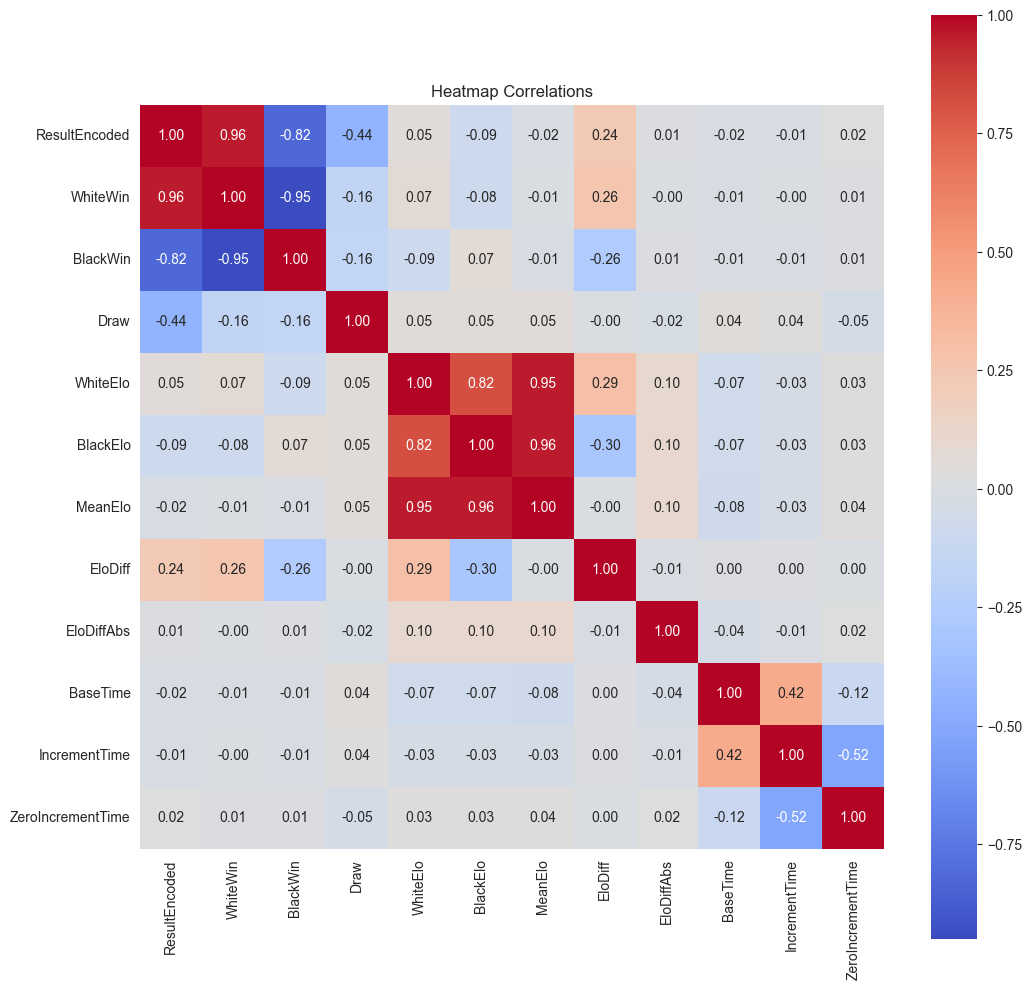

In [11]:
def plot_heatmap(data):
    reordered_columns = TARGET_COLUMNS + [
        col for col in data.columns if col not in TARGET_COLUMNS
    ]
    data = data[reordered_columns]

    numeric_df = data.select_dtypes(include="number")
    plt.figure(figsize=(12, 12))
    sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Heatmap Correlations")
    plt.show()


plot_heatmap(df)

White elo has positive correlation with white win and negative correlation with black win. Same for black elo.

Also, Elo has small correlation with draw.

Let's see the distribution of the results, where:
   - "1-0": White wins
   - "0-1": Black wins
   - "1/2-1/2": Draw

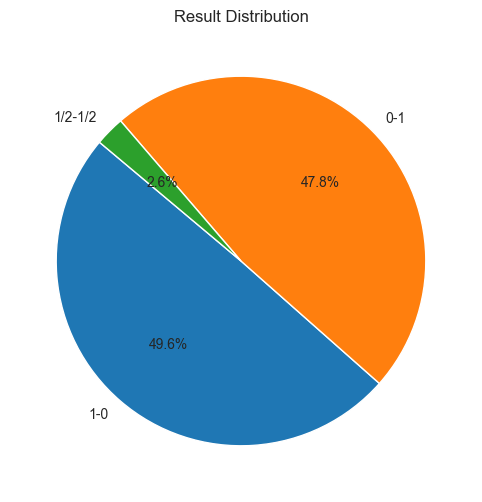

In [12]:
_, axs = plt.subplots(figsize=(12, 6))
plot_pie(axs, df, "Result", "Result Distribution", threshold=0)
plt.show()

And let's see the distribution of Events.

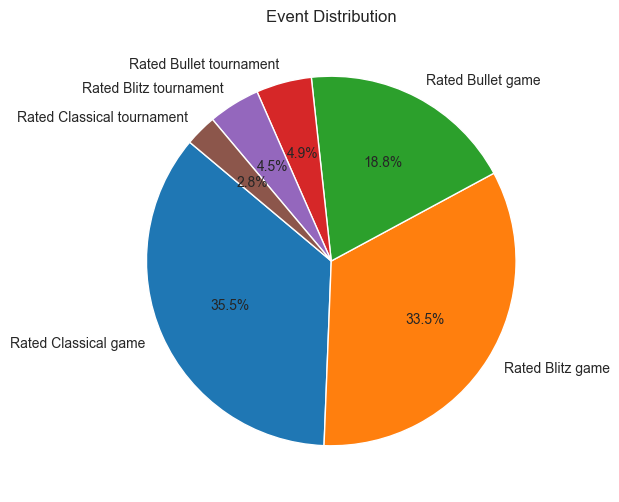

In [13]:
_, axs = plt.subplots(figsize=(12, 6))
plot_pie(axs, df, "Event", "Event Distribution", threshold=0)
plt.show()

And now - the distribution of the results for each event.

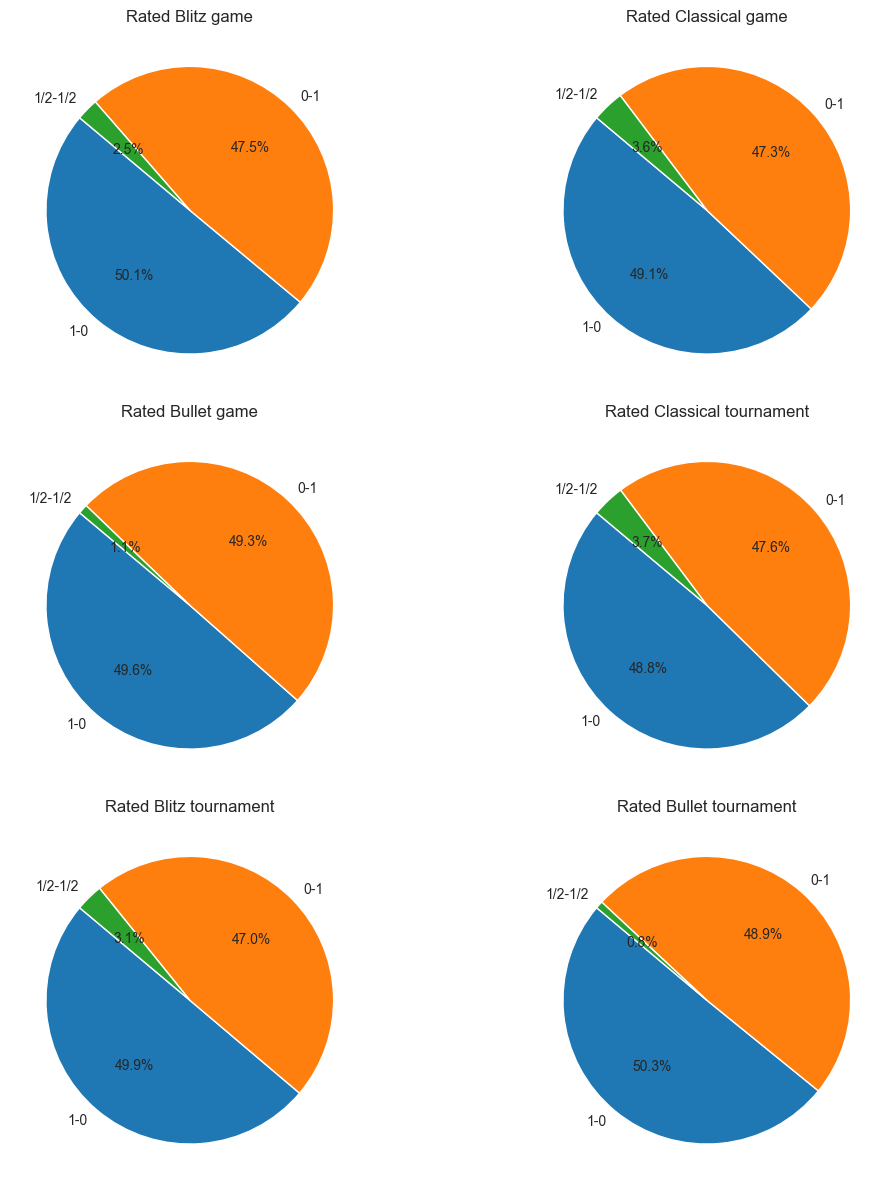

In [14]:
_, axs = plt.subplots(3, 2, figsize=(12, 12))
idx = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]

events = df["Event"].unique()
for (i, j), event in zip(idx, events):
    event_df = df[df["Event"] == event]
    plot_pie(axs[i][j], event_df, column_name="Result", title=f"{event}", threshold=0)

plt.tight_layout()
plt.show()

## Elo vs Result

Let's compare mean Elo of all games and mean Elo of draws.

Mean Elo: 1623.4574
Mean Elo for Draw: 1707.0508


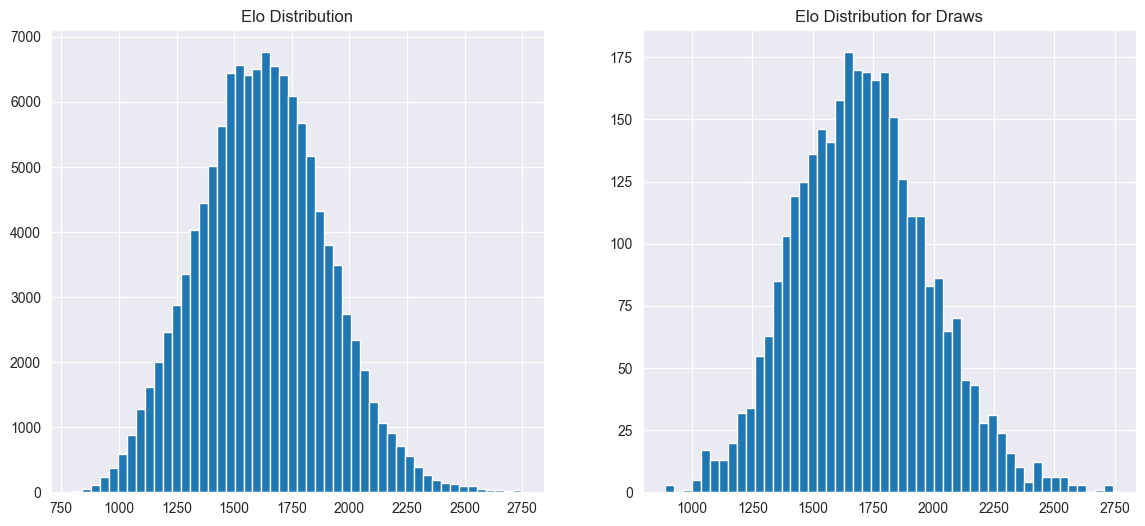

In [15]:
print("Mean Elo:", df["MeanElo"].mean())
print("Mean Elo for Draw:", df[df["Draw"] == 1]["MeanElo"].mean())

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

df["MeanElo"].hist(bins=50, ax=axes[0])
axes[0].set_title("Elo Distribution")

df[df["Draw"] == 1]["MeanElo"].hist(bins=50, ax=axes[1])
axes[1].set_title("Elo Distribution for Draws")

plt.show()

Draws have higher mean Elo.

And let's compare mean winner elo with mean loser elo

white Wins
White mean elo: 1643.8562306118408
Black mean elo: 1600.134974589136


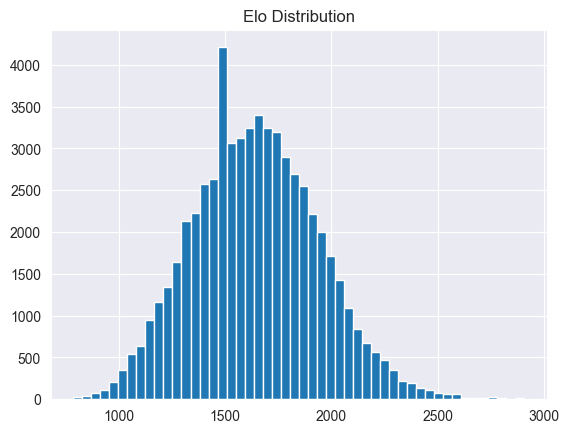

In [16]:
white_wins_df = df[df["WhiteWin"] == 1]
print("white Wins")
print("White mean elo:", white_wins_df["WhiteElo"].mean())
print("Black mean elo:", white_wins_df["BlackElo"].mean())

white_wins_df["WhiteElo"].hist(bins=50)
plt.title("Elo Distribution")
plt.show()

Black Wins
Black mean elo: 1644.3871326422388
White mean elo: 1596.5095111019878


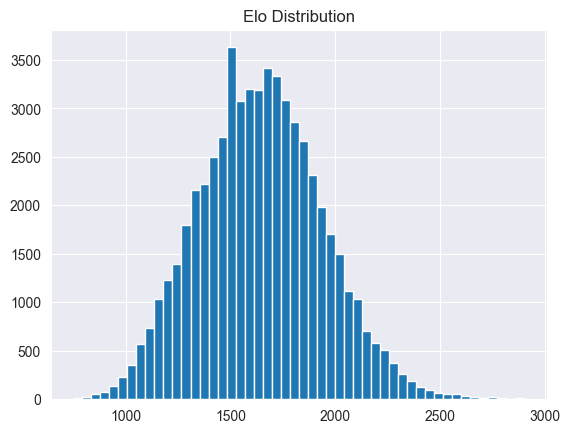

In [17]:
black_wins_df = df[df["BlackWin"] == 1]
print("Black Wins")
print("Black mean elo:", black_wins_df["BlackElo"].mean())
print("White mean elo:", black_wins_df["WhiteElo"].mean())

black_wins_df["BlackElo"].hist(bins=50)
plt.title("Elo Distribution")
plt.show()

In [18]:
del white_wins_df
del black_wins_df

## Time Control Exploration

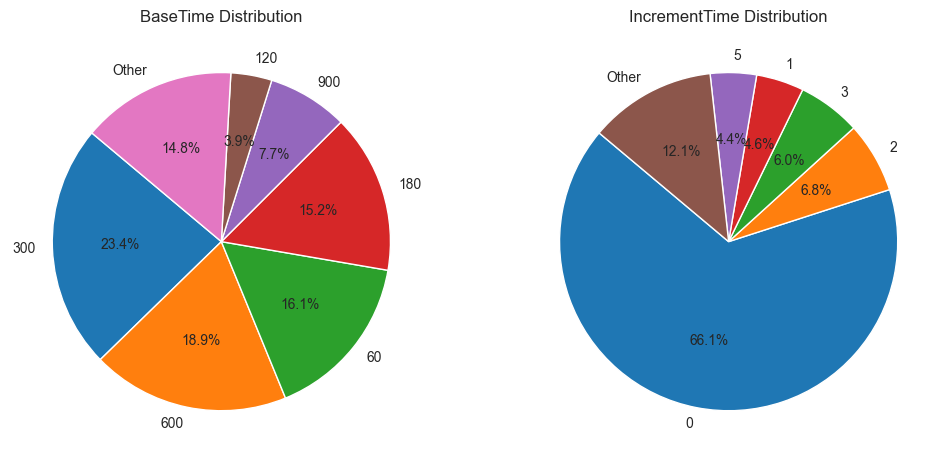

In [19]:
_, axs = plt.subplots(1, 2, figsize=(12, 6))
plot_pie(axs[0], df, "BaseTime", "BaseTime Distribution", threshold=0.03)
plot_pie(axs[1], df, "IncrementTime", "IncrementTime Distribution", threshold=0.04)
plt.show()

In [20]:
def plot_draw_percentage_by_base_time(data_df, base_times=None):
    """
    Plots the draw percentage by base time.

    :param data_df: DataFrame with "BaseTime" and "Draw" columns.
    :param base_times: Optional; either a list of specific base times or an integer n for the top n popular base times.
    """
    if base_times is None:
        base_time_df = data_df[["BaseTime", "Draw"]]
    elif isinstance(base_times, int):
        base_time_counts = data_df["BaseTime"].value_counts()
        top_base_times = base_time_counts.head(base_times).index
        base_time_df = data_df[data_df["BaseTime"].isin(top_base_times)][["BaseTime", "Draw"]]
    else:
        base_time_df = data_df[data_df["BaseTime"].isin(base_times)][["BaseTime", "Draw"]]

    pct_draw_values = base_time_df.groupby("BaseTime").mean() * 100

    _, plot_ax = plt.subplots(figsize=(12, 6))
    pct_draw_values.plot(kind="bar", ax=plot_ax)
    plot_ax.set_title("Draw Percentage by Base Time")
    plot_ax.set_ylabel("Draw Percentage (%)")
    plot_ax.set_xlabel("Base Time")
    plt.xticks(rotation=45)
    plt.show()

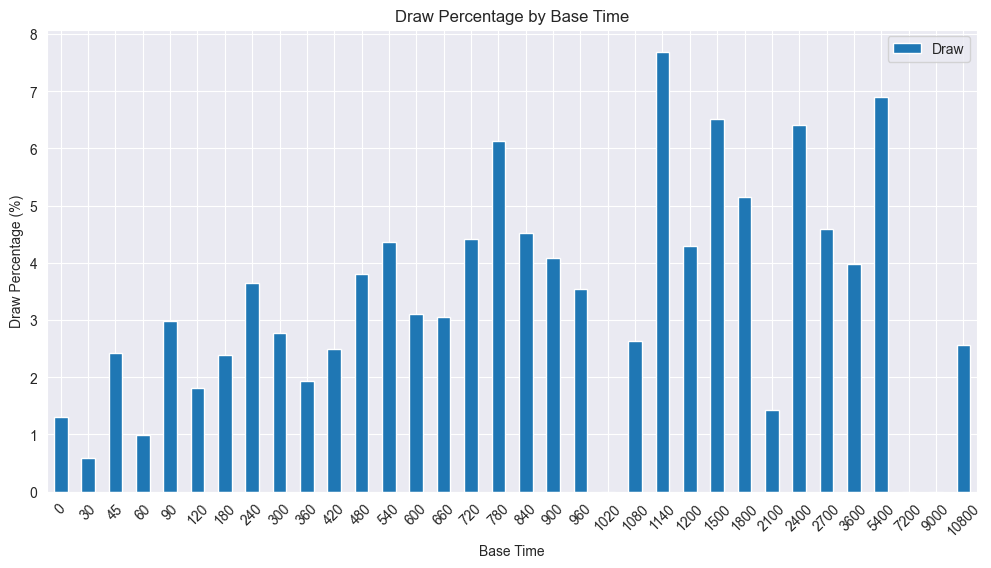

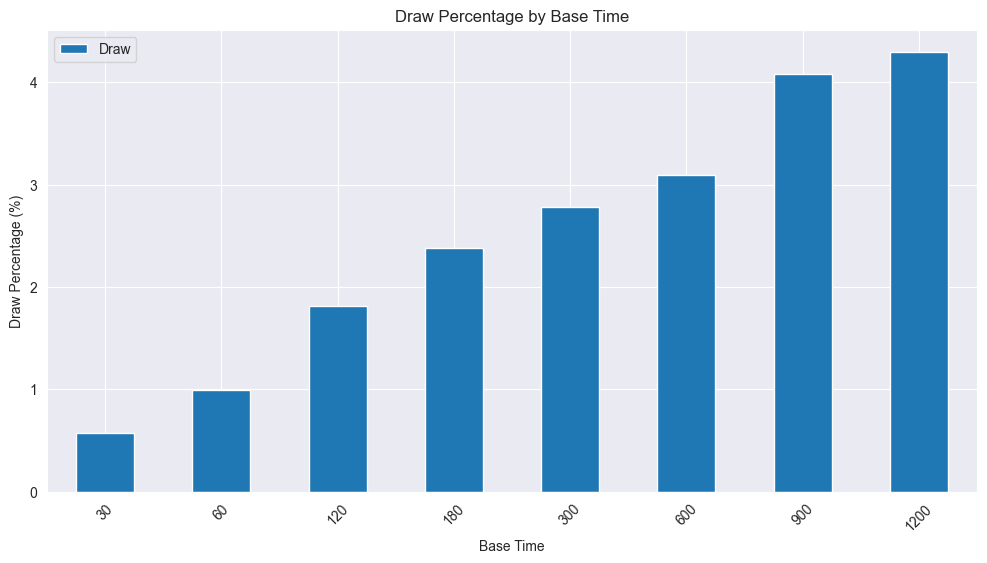

In [21]:
plot_draw_percentage_by_base_time(df)
plot_draw_percentage_by_base_time(df, base_times=8)

As more time is given, the draw percentage increases.

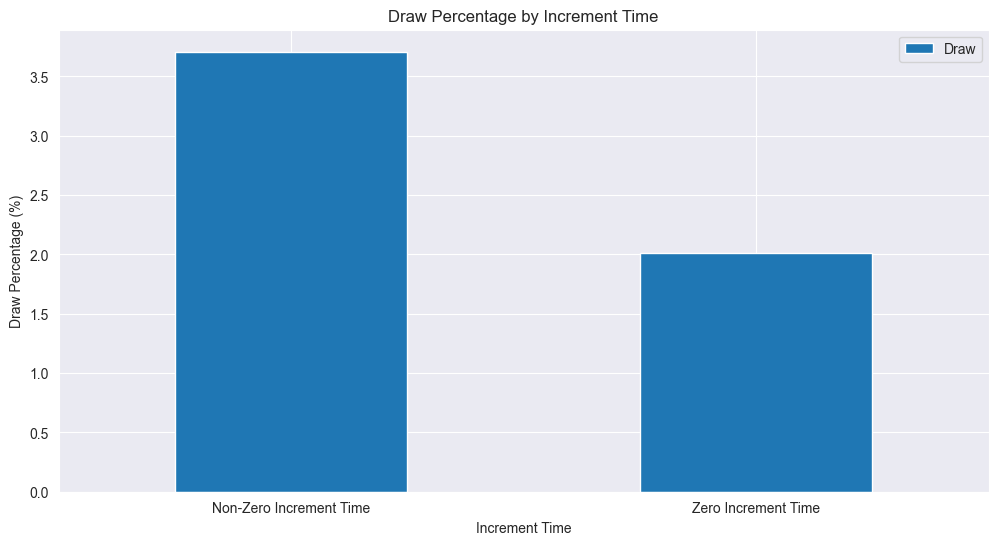

In [22]:
increment_time_df = df[["ZeroIncrementTime", "Draw"]].copy()
increment_time_df["ZeroIncrementTime"] = increment_time_df["ZeroIncrementTime"].map(
    {0: "Non-Zero Increment Time", 1: "Zero Increment Time"}
)
pct_draw_values = increment_time_df.groupby("ZeroIncrementTime").mean() * 100

ax = pct_draw_values.plot(kind="bar", figsize=(12, 6))
ax.set_title("Draw Percentage by Increment Time")
ax.set_ylabel("Draw Percentage (%)")
ax.set_xlabel("Increment Time")
plt.xticks(rotation=0)
plt.show()

non-zero increment time games have higher draw percentage.

In [23]:
df["DrawEventProb"] = df.groupby("Event")["Draw"].transform("mean")
df["WhiteWinEventProb"] = df.groupby("Event")["WhiteWin"].transform("mean")
df["BlackWinEventProb"] = df.groupby("Event")["BlackWin"].transform("mean")


In [24]:
# df["EventMeanElo"] = df.groupby("Event")["MeanElo"].transform("mean")
# df["EventMeanEloDiff"] = df.groupby("Event")["EloDiff"].transform("mean")
# df["EventMeanEloDiffAbs"] = df.groupby("Event")["EloDiffAbs"].transform("mean")

In [25]:
# df["MeanEloDivWhiteWinProb"] = df["MeanElo"] / df["WhiteWinEventProb"]
# df["MeanEloDivBlackWinProb"] = df["MeanElo"] / df["BlackWinEventProb"]
# df["MeanEloDivDrawProb"] = df["MeanElo"] / df["RawEventProb"]

In [26]:
# df["EloDiffDivWhiteWinProb"] = df["EloDiff"] / df["WhiteWinEventProb"]
# df["EloDiffDivBlackWinProb"] = df["EloDiff"] / df["BlackWinEventProb"]
# df["EloDiffDivDrawProb"] = df["EloDiff"] / df["RawEventProb"]

In [27]:
# df["EloDiffAbsDivWhiteWinProb"] = df["EloDiffAbs"] / df["WhiteWinEventProb"]
# df["EloDiffAbsDivBlackWinProb"] = df["EloDiffAbs"] / df["BlackWinEventProb"]
# df["EloDiffAbsDivDrawProb"] = df["EloDiffAbs"] / df["RawEventProb"]

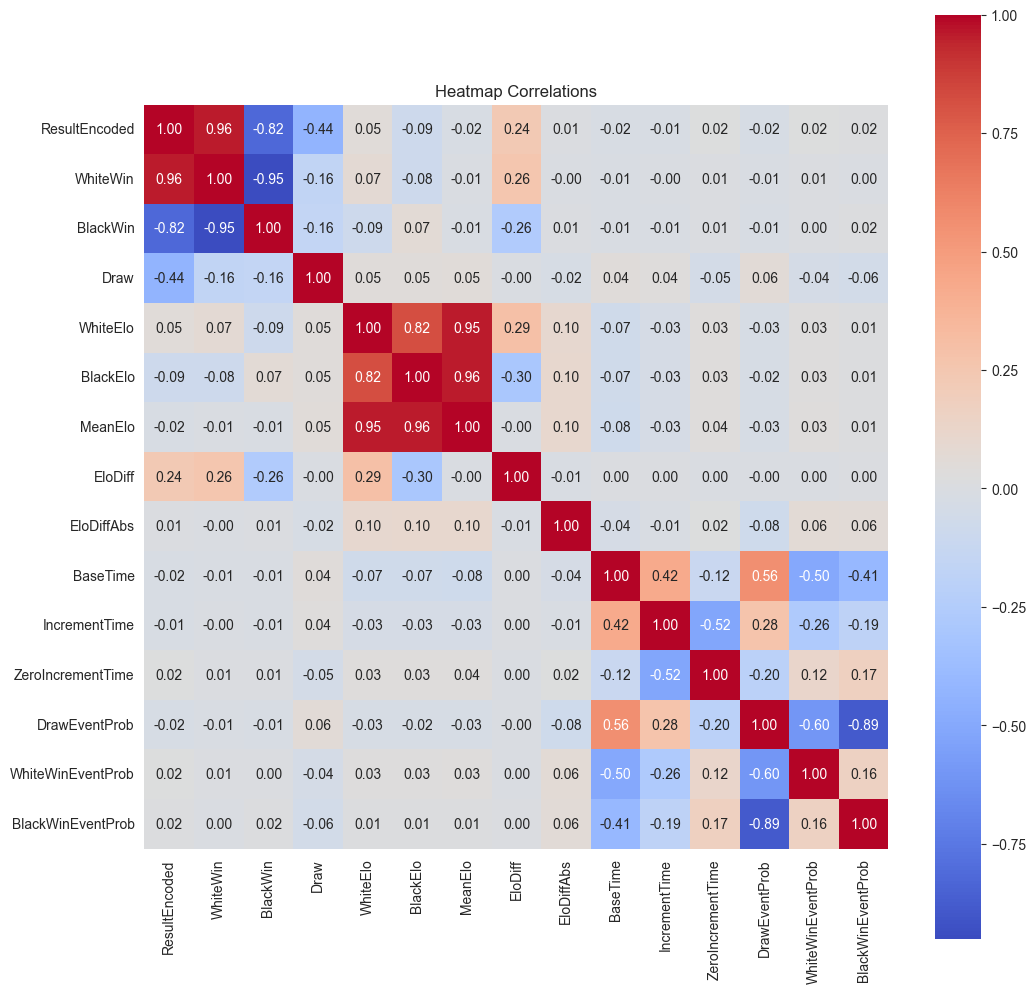

In [28]:
plot_heatmap(df)

In [29]:
df = pd.get_dummies(df, columns=["Event"], dtype=np.int8)

In [30]:
df.drop(columns=["Result"], inplace=True)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122226 entries, 0 to 122230
Data columns (total 21 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   WhiteElo                          122226 non-null  int16  
 1   BlackElo                          122226 non-null  int16  
 2   MeanElo                           122226 non-null  float32
 3   EloDiff                           122226 non-null  int16  
 4   EloDiffAbs                        122226 non-null  int16  
 5   BaseTime                          122226 non-null  int16  
 6   IncrementTime                     122226 non-null  int16  
 7   ZeroIncrementTime                 122226 non-null  int8   
 8   ResultEncoded                     122226 non-null  int64  
 9   WhiteWin                          122226 non-null  int8   
 10  BlackWin                          122226 non-null  int8   
 11  Draw                              122226 non-null  int8  

In [32]:
df.head()

,WhiteElo,BlackElo,MeanElo,EloDiff,EloDiffAbs,BaseTime,IncrementTime,ZeroIncrementTime,ResultEncoded,WhiteWin,...,Draw,DrawEventProb,WhiteWinEventProb,BlackWinEventProb,Event_Rated Blitz game,Event_Rated Blitz tournament,Event_Rated Bullet game,Event_Rated Bullet tournament,Event_Rated Classical game,Event_Rated Classical tournament
0,1234,1467,1350.5,-233,233,300,0,1,0,0,...,0,0.024715,0.500611,0.474674,1,0,0,0,0,0
1,1988,1960,1974.0,28,28,180,0,1,1,1,...,0,0.024715,0.500611,0.474674,1,0,0,0,0,0
2,1891,1900,1895.5,-9,9,300,0,1,1,1,...,0,0.024715,0.500611,0.474674,1,0,0,0,0,0
3,1342,1364,1353.0,-22,22,600,0,1,1,1,...,0,0.035965,0.490571,0.473465,0,0,0,0,1,0
4,1575,1630,1602.5,-55,55,900,15,0,0,0,...,0,0.035965,0.490571,0.473465,0,0,0,0,1,0


In [33]:
def estimate_prediction_by_elo(data_df: pd.DataFrame):
    white_elo_more_than_black = data_df["WhiteElo"] > data_df["BlackElo"]

    white_win_condition = white_elo_more_than_black & (data_df["WhiteWin"] == 1)
    black_win_condition = ~white_elo_more_than_black & (data_df["BlackWin"] == 1)
    
    right_predictions = len(data_df[white_win_condition]) + len(data_df[black_win_condition])
    return right_predictions / len(data_df)

In [34]:
estimate_prediction_by_elo(df)

0.5865855055389197